# 0. Setup

In [1]:
import sys
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import base64
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('jpg')

In [2]:
def show_board_and_squares(img, squares):
    """Display a chess board and its split squares side by side."""
    fig = plt.figure(figsize=(18, 9), dpi=50)
    gs = fig.add_gridspec(8, 16, hspace=0.15, wspace=0.15)
    
    # Left side: full board (spans 8 rows, 7 columns)
    ax_board = fig.add_subplot(gs[:, :7])
    ax_board.imshow(img, cmap='gray')
    
    # Add red border around the full board
    height, width = img.shape
    rect = patches.Rectangle((0, 0), width-1, height-1, 
                             linewidth=3, edgecolor='red', facecolor='none')
    ax_board.add_patch(rect)
    ax_board.axis('off')
    
    # Right side: 8x8 grid of squares
    for row, col, sq in squares:
        ax = fig.add_subplot(gs[row, col + 8])
        ax.imshow(sq, cmap='gray')
        
        # Add border around each square
        for spine in ax.spines.values():
            spine.set_edgecolor('darkgray')
            spine.set_linewidth(1.5)
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [3]:
dataset_path = Path('/kaggle/input/boards')

# 1. Load & Split Board into Squares

In [4]:
def load_image(image_path, target_size=(512, 512)):
    """Load image as grayscale and resize."""
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not load {image_path}")
    return cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

In [5]:
def split_into_squares(board, square_size=64):
    """Split 512x512 board into 8x8 equal squares."""
    bh, bw = board.shape
    step_h, step_w = bh // 8, bw // 8
    squares = []
    for row in range(8):
        for col in range(8):
            sq = board[row*step_h:(row+1)*step_h, col*step_w:(col+1)*step_w]
            sq = cv2.resize(sq, (square_size, square_size))
            squares.append((row, col, sq))
    return squares

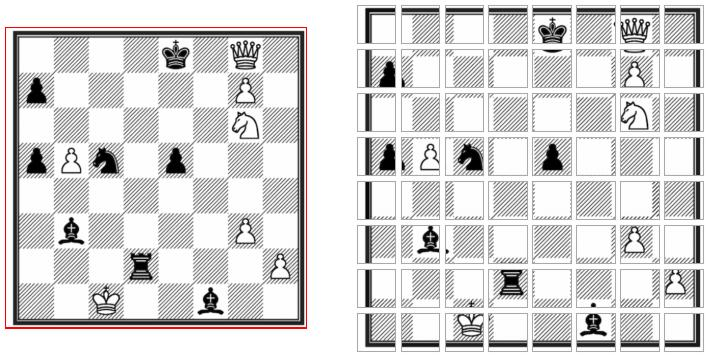

In [6]:
image_path = dataset_path / 'board000.png'
img = load_image(image_path)
squares = split_into_squares(img)

show_board_and_squares(img, squares)

# 2. Crop white padding

In [7]:
def crop_white_padding(img, threshold=140, target_size=(512, 512)):
    """Crop out uniform white padding around the chessboard."""
    mask = img < threshold
    if not mask.any():
        return img
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    y1, y2 = np.where(rows)[0][[0, -1]]
    x1, x2 = np.where(cols)[0][[0, -1]]
    cropped = img[y1:y2+1, x1:x2+1]
    resized = cv2.resize(cropped, target_size, interpolation=cv2.INTER_AREA)

    return resized

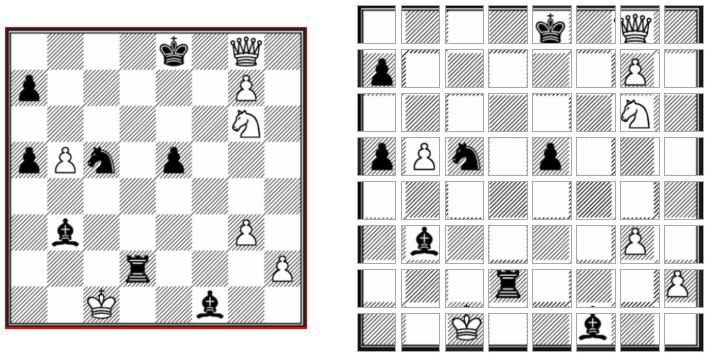

In [8]:
mg = load_image(image_path)
cropped = crop_white_padding(img)
squares = split_into_squares(cropped)

show_board_and_squares(cropped, squares)

# 3. Extract chessboard region

In [9]:
def binarize_image(img):
    """Convert grayscale to clean black-white using adaptive thresholding and denoise."""
    blurred = cv2.GaussianBlur(img, (5, 5), 0)

    # Step 1: adaptive threshold
    binary = cv2.adaptiveThreshold(
        blurred, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        11, 2
    )

    # Step 2: morphological cleanup (remove tiny black or white spots)
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=1)

    return binary

def find_edge(line, direction, min_white, threshold):
    """Find the first stable run of white pixels in a 1D line."""
    if direction == -1:
        line = line[::-1]
    white_count = 0
    run_start = None
    for i, px in enumerate(line):
        if px >= threshold:
            if white_count == 0:
                run_start = i
            white_count += 1
            if white_count >= min_white:
                idx = run_start
                return idx if direction == 1 else len(line) - 1 - idx
        else:
            white_count = 0
            run_start = None
    return 0 if direction == 1 else len(line) - 1
    
def extract_chessboard_region(img, min_white=7, threshold=140, target_size=(512, 512)):
    """
    Detect chessboard edges using binarized image, but crop and resize original.
    Samples multiple positions to find robust edge detection.
    """
    # Binarize for edge detection
    binary_img = binarize_image(img)
    
    h, w = binary_img.shape
    lr_offsets = [-10, 0, 10]
    tb_offsets = [-25, 0, 25]

    # --- Step 1: Detect LEFT and RIGHT edges on binary image ---
    left_edges = []
    right_edges = []
    
    for offset in lr_offsets:
        # LEFT edge: sample horizontal lines near top
        left_sample_row = h // 16 + offset
        if 0 <= left_sample_row < h:
            left_edge = find_edge(binary_img[left_sample_row, :], direction=1, 
                                 min_white=min_white, threshold=threshold)
            left_edges.append(left_edge)
        
        # RIGHT edge: sample horizontal lines near bottom
        right_sample_row = h - h // 16 + offset
        if 0 <= right_sample_row < h:
            right_edge = find_edge(binary_img[right_sample_row, :], direction=-1, 
                                  min_white=min_white, threshold=threshold)
            right_edges.append(right_edge)
    
    # Keep the smallest-left and largest-right edge
    left = min(left_edges) if left_edges else 0
    right = max(right_edges) if right_edges else w
    
    # Crop horizontally on binary image for further detection
    binary_h_crop = binary_img[:, left:right]
    h2, w2 = binary_h_crop.shape
    
    # --- Step 2: Detect TOP and BOTTOM edges on binary image ---
    top_edges = []
    bottom_edges = []
    
    for offset in tb_offsets:
        # TOP edge: sample vertical lines near left
        top_sample_col = w2 // 16 + offset
        if 0 <= top_sample_col < w2:
            top_edge = find_edge(binary_h_crop[:, top_sample_col], direction=1, 
                                min_white=min_white, threshold=threshold)
            top_edges.append(top_edge)
        
        # BOTTOM edge: sample vertical lines near right
        bottom_sample_col = w2 - w2 // 16 + offset
        if 0 <= bottom_sample_col < w2:
            bottom_edge = find_edge(binary_h_crop[:, bottom_sample_col], direction=-1, 
                                   min_white=min_white, threshold=threshold)
            bottom_edges.append(bottom_edge)
    
    # Keep the smallest-top and largest-bottom edges
    top = min(top_edges) if top_edges else 0
    bottom = max(bottom_edges) if bottom_edges else h2
    
    # Crop and resize the ORIGINAL image using detected coordinates
    cropped = img[top:bottom, left:right]
    resized = cv2.resize(cropped, target_size, interpolation=cv2.INTER_AREA)
    
    return resized

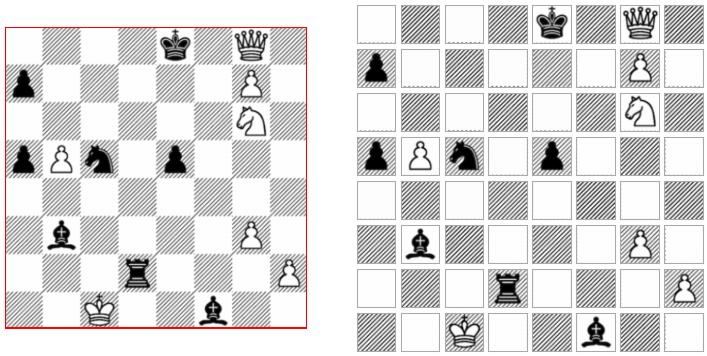

In [10]:
img = load_image(image_path)
cropped = crop_white_padding(img)
board = extract_chessboard_region(cropped)
squares = split_into_squares(board)

show_board_and_squares(board, squares)

# 4. Labeling
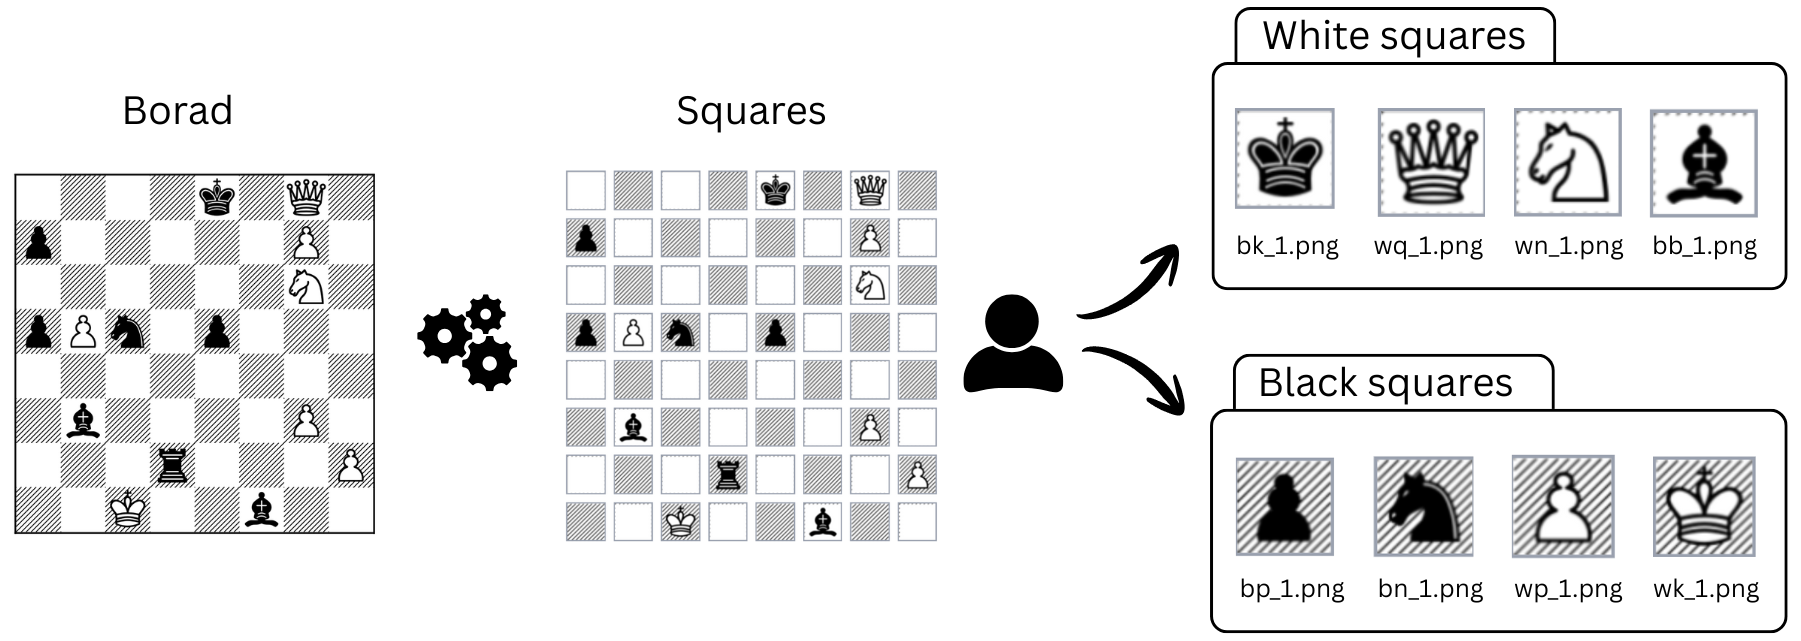

# 5. Data Augmentation

In [11]:
def crop_and_pad(img, border=2, target_size=64):
    """Crop border, pad to target size with background color."""
    h, w = img.shape
    cropped = img[border:h-border, border:w-border]
    
    # Background from 4 corners
    bg = int(np.median(cropped[[0, 0, -1, -1], [0, -1, 0, -1]]))
    
    # Pad to target size
    oh, ow = cropped.shape
    pad_v, pad_h = target_size - oh, target_size - ow
    
    return cv2.copyMakeBorder(
        cropped, 
        pad_v//2, pad_v - pad_v//2, 
        pad_h//2, pad_h - pad_h//2, 
        cv2.BORDER_CONSTANT, 
        value=bg
    )

def augment_image(img, max_trans=5, scale_range=(0.9, 1.1)):
    """Apply random scale, translation, and flip."""
    h, w = img.shape
    bg = int(np.median(img[[0, 0, -1, -1], [0, -1, 0, -1]]))
    
    # Affine transformation matrix
    scale = random.uniform(*scale_range)
    M = cv2.getRotationMatrix2D((w/2, h/2), 0, scale)
    M[0, 2] += random.randint(-max_trans, max_trans)
    M[1, 2] += random.randint(-max_trans, max_trans)
    
    aug = cv2.warpAffine(img, M, (w, h), borderValue=bg)
    
    return cv2.flip(aug, 1) if random.random() < 0.5 else aug

def generate_augmentations(img, count=5):
    """Standardize image and generate augmentations."""
    base = crop_and_pad(img)
    return [base] + [augment_image(base) for _ in range(count)]

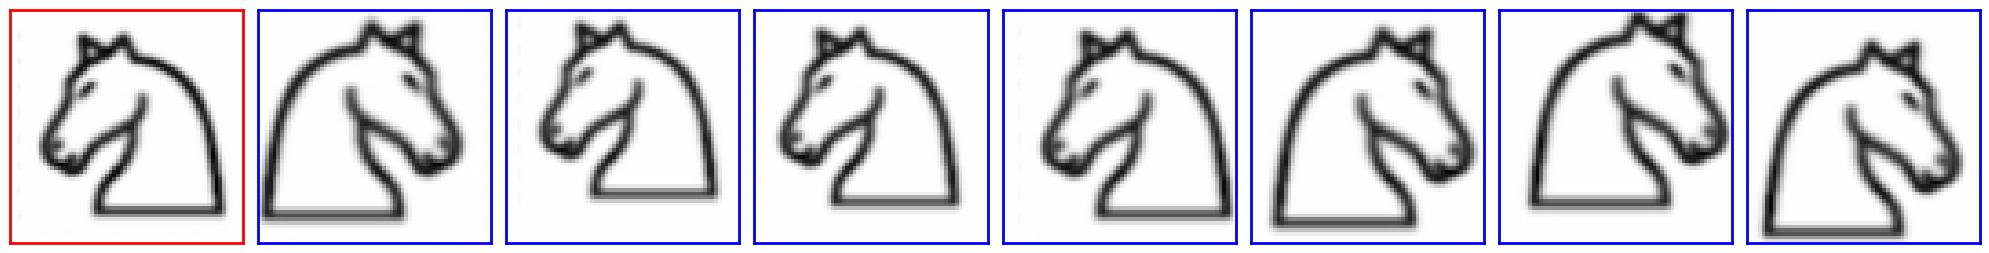

In [12]:
# Get sample and generate augmentations
original_sq = squares[22][2]
augmented_batch = generate_augmentations(original_sq, count=7)

# Visualize
def plot_augmentations(imgs):
    fig, axes = plt.subplots(1, len(imgs), figsize=(2.5*len(imgs), 3))
    axes = [axes] if len(imgs) == 1 else axes
    
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img, cmap='gray', vmin=0, vmax=255)
        ax.set_xticks([])
        ax.set_yticks([])
        color = 'red' if i == 0 else 'blue'
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(2)
    
    plt.tight_layout()
    plt.show()

plot_augmentations(augmented_batch)

# 6. Base64 Encoding

In [13]:
def squares_to_base64(squares):
    squares_b64 = []
    for row, col, sq in squares:
        _, buffer = cv2.imencode('.png', sq)
        b64_str = base64.b64encode(buffer).decode('utf-8')
        squares_b64.append(b64_str)
    return squares_b64

In [14]:
squares_to_base64(squares)[22][:100]+'...'

'iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAAAAACPAi4CAAAJDElEQVRYCZ3BeVDWdR4H8Pf7+3tuQES5UVBOFcVbUwg1zQOVlMpz...'